In [4]:
import json

import nptsne
import numpy as np
from nptsne import hsne_analysis
import pandas as pd

### THERE ARE NO CliffDiving ACTIONS -> So 19 + 1 classes

In [5]:
X = np.load("C:\\Users\\alexa\\Desktop\\Thumos14\\features_test_set.npy")
GT_LABELS = pd.read_csv("C:\\Users\\alexa\\Desktop\\Thumos14\\labels_test_set_gt.csv", header=0)
# print(labels.iloc[0]["segment_gt_label"])

### Create HSNE with 4 scales

In [31]:
def create_hsne(scales = 4):
    print(f'Size data: {X.shape}')
    hsne = nptsne.HSne(True)
    hsne.create_hsne(X, scales)
    print(f'Num scales: {hsne.num_scales} Num points {hsne.num_data_points}')
    return hsne

In [32]:
def create_top_analysis(hsne, iterations = 500):
    top_analysis = nptsne.hsne_analysis.Analysis(hsne,nptsne.hsne_analysis.EmbedderType.GPU)
    for i in range(iterations):
        top_analysis.do_iteration()
    return top_analysis

In [33]:
def create_new_analysis(hsne, points, parent_analysis, iterations = 500):
    new_analysis = nptsne.hsne_analysis.Analysis(hsne, embedder_type= nptsne.hsne_analysis.EmbedderType.GPU, parent=parent_analysis, parent_selection=points)
    for i in range(iterations):
        new_analysis.do_iteration()
    return new_analysis

In [34]:
import matplotlib.pyplot as plt

def plot_analysis(analysis):
    x_coords = [point[0] for point in analysis.embedding]
    y_coords = [point[1] for point in analysis.embedding]
    
    # Create scatter plot
    plt.scatter(x_coords, y_coords, s=5, color='blue')
    
    plt.grid(True)  # Enable grid
    plt.show()


In [35]:
from sklearn.cluster import AgglomerativeClustering
def create_clustering(analysis, n_clusters):
    print(np.shape(analysis.embedding))
    points = analysis.embedding
    agglomerativeClustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="single")
    agglomerativeClustering.fit(points)
    return agglomerativeClustering

In [36]:
hsne = create_hsne(3)
top_analysis = create_top_analysis(hsne)

Size data: (337180, 2048)
Num scales: 3 Num points 337180


In [10]:
from sklearn.cluster import DBSCAN, OPTICS, HDBSCAN, KMeans, MeanShift, SpectralClustering, AgglomerativeClustering
points = top_analysis.embedding
# dbscan = DBSCAN(eps=3, min_samples=2)  # Adjust parameters as needed
# dbscan.fit(points)
# optics = OPTICS(min_samples=200)
# optics.fit(points)
# hdb = HDBSCAN(min_cluster_size=30)
# hdb.fit(points)
kmeans = KMeans(n_init = "auto", n_clusters=20)
kmeans.fit(points)
mean_shift = MeanShift()
mean_shift.fit(points)
spectralClustering = SpectralClustering(n_clusters=20)
spectralClustering.fit(points)
agglomerativeClustering = AgglomerativeClustering(n_clusters=20, linkage="single")
agglomerativeClustering.fit(points)

# Retrieve cluster labels
# cluster_labels_dbscan = dbscan.labels_
# cluster_labels_optics = optics.labels_ 
# cluster_labels_hdb = hdb.labels_
cluster_labels_kmeans = kmeans.labels_
cluster_labels_meanshift = mean_shift.labels_
cluster_labels_spectralClustering = spectralClustering.labels_
cluster_labels_agglomerativeClustering = agglomerativeClustering.labels_


plt.scatter(points[:, 0], points[:, 1], c=cluster_labels_agglomerativeClustering, cmap='plasma', s=10)
plt.title('Agglomerative Clustering - Single Linkage')
plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics.cluster import contingency_matrix
gt_labels_top_scale = GT_LABELS[GT_LABELS["segment_id"].isin(top_analysis.landmark_orig_indexes)]
contingency_matrix = contingency_matrix(gt_labels_top_scale["segment_gt_label"], cluster_labels_agglomerativeClustering)
# Fix the indexing
contingency_matrix_df = pd.DataFrame(contingency_matrix, 
                               index=pd.unique(gt_labels_top_scale["segment_gt_label"]), 
                               columns=range(20))

file_path = 'contingency_matrix_test_3.xlsx'
contingency_matrix_df.to_excel(file_path)

print("Confusion matrix saved to:", file_path)

In [2]:
def get_total_labels_per_class():
    unique, counts = np.unique(GT_LABELS["segment_gt_label"], return_counts=True)
    total_labels = dict(zip(unique, counts))
    return total_labels

In [6]:
from sklearn import metrics
def calculate_purity(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [7]:
def get_true_labels_for_analysis(analysis):
    original_indexes = analysis.landmark_orig_indexes
    return GT_LABELS[GT_LABELS["segment_id"].isin(original_indexes)]["segment_gt_label"]

In [8]:
def find_gt_labels_in_analysis(analysis):
    original_indexes = analysis.landmark_orig_indexes
    unique, counts = np.unique(GT_LABELS[GT_LABELS["segment_id"].isin(original_indexes)]["segment_gt_label"], return_counts=True)
    return dict(zip(unique,counts))

In [9]:
def find_number_of_gt_labels_in_analysis(analysis):
    original_indexes = analysis.landmark_orig_indexes
    return len(pd.unique(GT_LABELS[GT_LABELS["segment_id"].isin(original_indexes)]["segment_gt_label"]))

In [42]:
class ComparableAnalysis:
    def __init__(self, number_of_points, analysis):
        self.number_of_points = number_of_points
        self.analysis = analysis
    
    def __lt__(self, other):
        return self.number_of_points < other.number_of_points
    
    def __eq__(self, other):
        return self.analysis.id == other.analysis.id

### Assume perfect annotation at last level

In [43]:
from collections import defaultdict
import queue


def bfs(hsne, top_analysis, always_most_points = False, dfs = True):
    # purities_per_scale = defaultdict(list)
    remaining_labels_per_class = get_total_labels_per_class()
    initial_labels_per_class = get_total_labels_per_class()
    complete_annotated_classes = []
    percentage_annotated = []
    sum_points = 0
    annotated_classes = set()
    if dfs:
        queue_analysis = queue.LifoQueue()
    elif always_most_points:
        queue_analysis = queue.PriorityQueue()
    else:
        queue_analysis = queue.Queue()
    queue_analysis.put(ComparableAnalysis(top_analysis.number_of_points, top_analysis))
    while not queue_analysis.empty():
        print(percentage_annotated)
        print("Remaining labels", remaining_labels_per_class)
        current_analysis = queue_analysis.get().analysis
        if current_analysis.scale_id == 0:
            current_labels = find_gt_labels_in_analysis(current_analysis)
            print("Current labels", current_labels)
            print(current_analysis.number_of_points)
            sum_points += current_analysis.number_of_points
            for key in current_labels.keys():
                remaining_labels_per_class[key] -= current_labels[key]
                avg_annotated = []
                for k in initial_labels_per_class.keys():
                    avg_annotated.append((initial_labels_per_class[k] - remaining_labels_per_class[k]) / initial_labels_per_class[k])
                print(avg_annotated)
                percentage_annotated.append(sum(avg_annotated)/len(avg_annotated))
                        
                # if remaining_labels_per_class[key] > 0:
                #     remaining_labels_per_class[key] -= current_labels[key]
                #     if remaining_labels_per_class[key] <= 0.1 * initial_labels_per_class[key]:
                #         annotated_classes.add(key)
        # complete_annotated_classes.append(len(annotated_classes))
        avg_annotated = []
        for k in initial_labels_per_class.keys():
            avg_annotated.append((initial_labels_per_class[k] - remaining_labels_per_class[k]) / initial_labels_per_class[k])
        percentage_annotated.append(sum(avg_annotated)/len(avg_annotated))
        amount_of_labels = find_number_of_gt_labels_in_analysis(current_analysis)
        if amount_of_labels > 0 and current_analysis.number_of_points >= 1:
            if current_analysis.scale_id != 0:
                clustering = create_clustering(current_analysis, amount_of_labels)
                for label in np.unique(clustering.labels_):
                    new_points = np.where(clustering.labels_ == label)[0]
                    iterations = 500
                    # if len(new_points) < 50:
                    #     iterations = 50
                    temp_analysis = create_new_analysis(hsne,new_points.tolist(),current_analysis, iterations)
                    #multiplied by -1 so I get inverse order for the PriorityQueue
                    queue_analysis.put(ComparableAnalysis(-1 * temp_analysis.number_of_points, temp_analysis))
    # print(purities_per_scale)
    # print(annotated_amount)
    print(sum_points)
    print("Remaining labels", remaining_labels_per_class)
    return percentage_annotated

    

In [44]:
import json
complete_annotated_classes = bfs(hsne, top_analysis, always_most_points=False)
with open("C:\\msc\\msc\\Experiments_output\\Percentage_annotated_test_features_3_scales_last_level_dfs.json", "w") as file:
    json.dump(complete_annotated_classes, file)
# with open("C:\\msc\\msc\\Experiments_output\\Purity_test_features_5_scales.json", "w") as file:
#     json.dump(purities, file)

[]
Remaining labels {'Background': 230567, 'BaseballPitch': 875, 'BasketballDunk': 6705, 'Billiards': 1828, 'CleanAndJerk': 7965, 'CricketBowling': 1819, 'CricketShot': 1986, 'Diving': 9593, 'FrisbeeCatch': 1240, 'GolfSwing': 1935, 'HammerThrow': 12427, 'HighJump': 6466, 'JavelinThrow': 8317, 'LongJump': 7896, 'PoleVault': 20855, 'Shotput': 6317, 'SoccerPenalty': 1134, 'TennisSwing': 2432, 'ThrowDiscus': 3712, 'VolleyballSpiking': 3111}
(9176, 2)
[0.0]
Remaining labels {'Background': 230567, 'BaseballPitch': 875, 'BasketballDunk': 6705, 'Billiards': 1828, 'CleanAndJerk': 7965, 'CricketBowling': 1819, 'CricketShot': 1986, 'Diving': 9593, 'FrisbeeCatch': 1240, 'GolfSwing': 1935, 'HammerThrow': 12427, 'HighJump': 6466, 'JavelinThrow': 8317, 'LongJump': 7896, 'PoleVault': 20855, 'Shotput': 6317, 'SoccerPenalty': 1134, 'TennisSwing': 2432, 'ThrowDiscus': 3712, 'VolleyballSpiking': 3111}
(51, 2)
[0.0, 0.0]
Remaining labels {'Background': 230567, 'BaseballPitch': 875, 'BasketballDunk': 6705, 

In [20]:
# hsne.save("save_test.hsne")


[0.7875457875457875, 0.8328939230280644, 0.826684442853377, 0.8814527772776997]


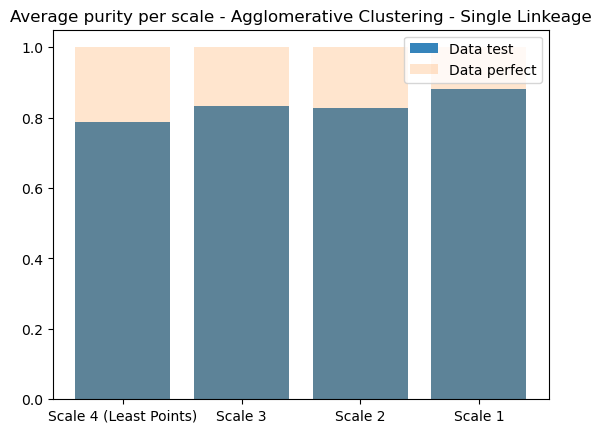

In [234]:
data_test = []
data_perfect = [1,1,1,1]
indexes = ["Scale 4 (Least Points)","Scale 3","Scale 2", "Scale 1"]

with open("C:\\msc\\msc\\Experiments_output\\Purity_test_features_5_scales.txt", "r") as file:
    data = json.load(file)
    for i in range(4,0,-1):
        data_test.append(np.mean(data[f"{i}"]))
        
print(data_test)    

plt.bar(indexes, data_test, alpha=0.9, label='Data test')
plt.bar(indexes, data_perfect, alpha=0.2, label='Data perfect')

plt.legend(loc='upper right') 
plt.title('Average purity per scale - Agglomerative Clustering - Singmaigle Linkeage') 
plt.show()

In [5]:
print(get_total_labels_per_class())

{'Background': 230567, 'BaseballPitch': 875, 'BasketballDunk': 6705, 'Billiards': 1828, 'CleanAndJerk': 7965, 'CricketBowling': 1819, 'CricketShot': 1986, 'Diving': 9593, 'FrisbeeCatch': 1240, 'GolfSwing': 1935, 'HammerThrow': 12427, 'HighJump': 6466, 'JavelinThrow': 8317, 'LongJump': 7896, 'PoleVault': 20855, 'Shotput': 6317, 'SoccerPenalty': 1134, 'TennisSwing': 2432, 'ThrowDiscus': 3712, 'VolleyballSpiking': 3111}


In [13]:
amount_annotated = {}
labels = get_total_labels_per_class()
for k in  list(labels.keys()):
    amount_annotated[k] = 0

final_annotated_50000 = []
with open("C:\\msc\\msc\\Experiments_output\\annotating_50000_points.txt", "r") as file:
    for line in file:
        splits = line.split(",")
        for split in splits:
            if split != "0":
                points = split.split("-")
                values = points[0]
                key = points[1]
                if key == "Bckg":
                    amount_annotated["Background"] += int(values)
                else:
                    amount_annotated[key] += int(values)
            annotated = []
            for k in list(amount_annotated.keys()):
                annotated.append(min(amount_annotated[k]/labels[k],1))                
            final_annotated_50000.append(sum(annotated)/len(annotated))

final_annotated_50000_y = range(len(final_annotated_50000))

In [17]:
amount_annotated = {}
labels = get_total_labels_per_class()
for k in  list(labels.keys()):
    amount_annotated[k] = 0

final_annotated_human = []
with open("C:\\msc\\msc\\Experiments_output\\Annotating_human_drill.txt", "r") as file:
    for line in file:
        splits = line.split(",")
        for split in splits:
            if split != "0":
                points = split.split("-")
                values = points[0]
                key = points[1]
                if key == "Bckg":
                    amount_annotated["Background"] += int(values)
                else:
                    amount_annotated[key] += int(values)
            annotated = []
            for k in list(amount_annotated.keys()):
                annotated.append(min(amount_annotated[k]/labels[k],1))                
            final_annotated_human.append(sum(annotated)/len(annotated))

final_annotated_human_y = range(len(final_annotated_human))

In [18]:
amount_annotated = {}
labels = get_total_labels_per_class()
for k in  list(labels.keys()):
    amount_annotated[k] = 0

final_annotated_25000 = []
with open("C:\\msc\\msc\\Experiments_output\\annotating_25000_points.txt", "r") as file:
    for line in file:
        splits = line.split(",")
        for split in splits:
            if split != "0":
                points = split.split("-")
                values = points[0]
                key = points[1]
                if key == "Bckg":
                    amount_annotated["Background"] += int(values)
                else:
                    amount_annotated[key] += int(values)
            annotated = []
            for k in list(amount_annotated.keys()):
                annotated.append(min(amount_annotated[k]/labels[k],1))                
            final_annotated_25000.append(sum(annotated)/len(annotated))

final_annotated_25000_y = range(len(final_annotated_25000))

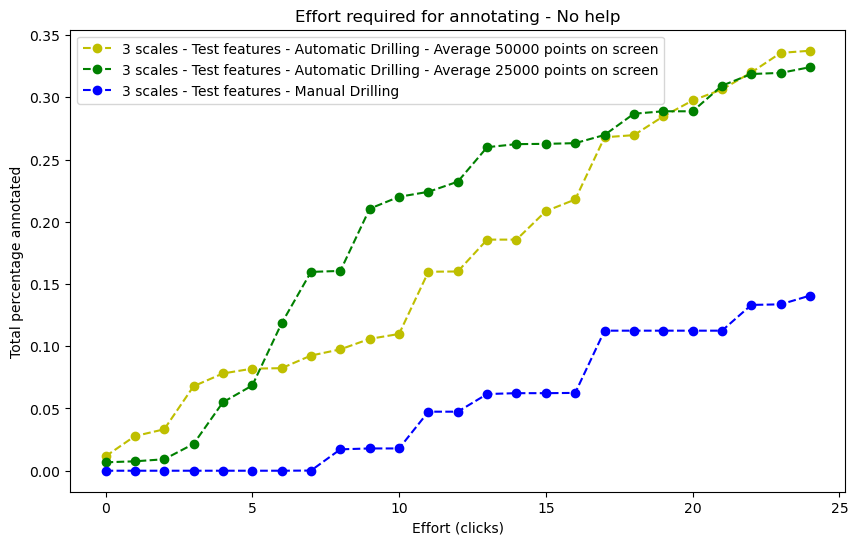

In [20]:
import json
import matplotlib.pyplot as plt

x_1 = []
y_1 = []
x_2 = []
y_2 = []
x_3 = []
y_3 = []
x_4 = []
y_4 = []
x_5 = []
y_5 = []
x_6 = []
y_6 = []

with open("C:\\msc\\msc\\Experiments_output\\Percentage_annotated_test_features_3_scales_last_level_dfs.json", "r") as file:
    data = json.load(file)
    c = 0
    for i, val in enumerate(data):
        x_2.append(i)
        y_2.append(val)
        
with open("C:\\msc\\msc\\Experiments_output\\Percentage_annotated_test_features_3_scales_last_level_dfs_uniform.json", "r") as file:
    data = json.load(file)
    c = 0
    for i, val in enumerate(data):
        x_3.append(i)
        y_3.append(val)
        

plt.figure(figsize=(10, 6))
plt.title("Effort required for annotating - No help")
plt.plot(final_annotated_50000_y,final_annotated_50000,"yo--",label="3 scales - Test features - Automatic Drilling - Average 50000 points on screen")
plt.plot(final_annotated_25000_y,final_annotated_25000,"go--",label="3 scales - Test features - Automatic Drilling - Average 25000 points on screen")
plt.plot(final_annotated_human_y,final_annotated_human,"bo--",label="3 scales - Test features - Manual Drilling")
# plt.plot(x_2,y_2,"bo--",label="3 scales - Test features - HSNE - DFS")
# plt.plot(x_3,y_3,"go--",label="3 scales - Test features - Uniform - DFS")

plt.xlabel("Effort (clicks)")
plt.ylabel("Total percentage annotated")
plt.legend()
# plt.savefig("C:\\msc\\msc\\Experiments_output\\annotating_effort_uni.png")
plt.show()